In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [2]:
%matplotlib inline

import itertools
from session.sessions import selected_009266, selected_008229, selected_009265, selected_57
from imports import *
from scipy import stats
from scipy import signal
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D
from population import unit_response_matrix, activity_at_phase
from umap import UMAP
from sklearn import decomposition

2024-07-26 09:21:34.940927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-26 09:21:35.082598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-26 09:21:35.082614: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-26 09:21:35.123082: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 09:21:37.067794: W tensorflow/stream_executor/platform/de

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
#source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'

sessions = [s for s in selected_009265.keys()]
sessions.sort()

sessions = selected_57
sessions.sort()

session = sessions[4]
session

'57_SIT_2023-12-23_14-21-01'

In [5]:
# global vars
fit_type = 'tSNE'
fit_parm = 70
speed_thresh = 0.04  # m/s
bin_count = 100

In [6]:
def get_profiles_per_cluster(session):
    animal = session.split('_')[0]
    s_path    = os.path.join(source, animal, session)
    meta_file = os.path.join(source, animal, session, 'meta.h5')
    desc_file = os.path.join(source, animal, session, 'descendants.h5')
    bMAP_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    segm_file = os.path.join(source, animal, session, 'analysis', 'bMAP_segmentation.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(bMAP_file, 'r') as f:
        syl_ratio_mx = np.array(f['syl_ratio_mx'])
        idxs_srm_tl  = np.array(f['idxs_srm_tl'])
        fit = np.array(f[fit_type][str(fit_parm)])
    with h5py.File(segm_file, 'r') as f:
        labels_ev = np.array(f['labels_ev'])
        tgt_succ_lbl_map = np.array(f['segmentation_TGT_succ'])
        
    # syllable statistics
    syl_usages = np.array([syl_ratio_mx[:, i].mean() for i in range(syl_ratio_mx.shape[1])])
    syl_count  = len(syl_usages)

    clusters = np.unique(labels_ev)  # just cluster numbers
    succ_clu = np.unique(tgt_succ_lbl_map)
    succ_clu = np.delete(succ_clu, np.where(succ_clu == 0)[0])

    clu_profile_means = np.zeros([len(clusters), syl_count])
    clu_profile_stds  = np.zeros([len(clusters), syl_count])  # or take stats.sem?
    for i, clu in enumerate(clusters):
        behaviors = syl_ratio_mx[labels_ev == clu]

        clu_profile_means[i] = behaviors.mean(axis=0)
        clu_profile_stds[i]  = behaviors.std(axis=0)
        
    return clu_profile_means, clu_profile_stds, succ_clu  # dim1 - clusters, dim2 - syllables

In [7]:
def get_avg_succ_profile(session):
    animal = session.split('_')[0]
    s_path    = os.path.join(source, animal, session)
    meta_file = os.path.join(source, animal, session, 'meta.h5')
    desc_file = os.path.join(source, animal, session, 'descendants.h5')
    bMAP_file = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')
    segm_file = os.path.join(source, animal, session, 'analysis', 'bMAP_segmentation.h5')

    with h5py.File(meta_file, 'r') as f:
        tl = np.array(f['processed']['timeline'])
        tgt_mx = np.array(f['processed']['target_matrix'])
        events = np.array(f['processed']['sound_events'])
    with h5py.File(bMAP_file, 'r') as f:
        syl_ratio_mx = np.array(f['syl_ratio_mx'])
        idxs_srm_tl  = np.array(f['idxs_srm_tl'])
        fit = np.array(f[fit_type][str(fit_parm)])
    with h5py.File(segm_file, 'r') as f:
        labels_ev = np.array(f['labels_ev'])
        tgt_succ_lbl_map = np.array(f['segmentation_TGT_succ'])
        idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev']).astype(np.int32)
        
    succ_clu = np.unique(tgt_succ_lbl_map)
    succ_clu = np.delete(succ_clu, np.where(succ_clu == 0)[0])

    behaviors = syl_ratio_mx[idxs_tgt_succ_state_ev]
        
    return behaviors.mean(axis=0), behaviors.std(axis=0), succ_clu  # dim1 - clusters, dim2 - syllables

## Profiles for each cluster in a single session

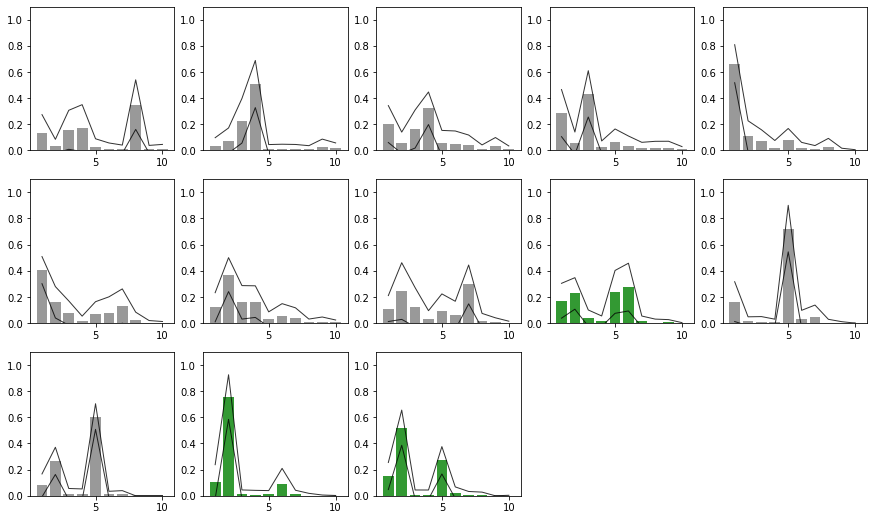

In [8]:
clu_profile_means, clu_profile_stds, succ_clu = get_profiles_per_cluster(session)
clusters = np.arange(clu_profile_means.shape[0]).astype(np.int16) + 1
syll_ids = np.arange(clu_profile_means.shape[1]).astype(np.int16) + 1

cols = 5
rows = int(len(clusters)/cols) + 1
fig = plt.figure(figsize=(15, 3*rows))

#def to_scaled(vec):
#    return vec/(np.abs(vec.min() - vec.max()))

for i, clu in enumerate(clusters):
    ax = fig.add_subplot(rows, cols, i+1)
    clr = 'green' if clu in succ_clu else 'gray'

    #ax.bar(syll_ids, to_scaled(clu_profile_means[i]*syl_usages), alpha=0.8, color=clr)
    ax.bar(syll_ids, clu_profile_means[i], alpha=0.8, color=clr)
    ax.plot(syll_ids, clu_profile_means[i] + clu_profile_stds[i], alpha=0.8, color='black', lw=1)
    ax.plot(syll_ids, clu_profile_means[i] - clu_profile_stds[i], alpha=0.8, color='black', lw=1)
    ax.set_ylim(0, 1.1)

## Cross-session AL profiles

In [9]:
selected = sessions[:]
selected

['57_SIT_2023-12-18_14-07-34',
 '57_SIT_2023-12-22_14-08-07',
 '57_SIT_2023-12-22_14-43-58',
 '57_SIT_2023-12-22_17-37-18',
 '57_SIT_2023-12-23_14-21-01',
 '57_SIT_2023-12-28_16-43-28',
 '57_SIT_2023-12-29_11-06-26',
 '57_SIT_2023-12-29_11-40-14',
 '57_SIT_2023-12-29_12-11-46',
 '57_SIT_2024-01-02_14-43-18',
 '57_SIT_2024-01-02_16-38-05',
 '57_SIT_2024-01-02_17-10-09',
 '57_SIT_2024-01-03_19-22-18',
 '57_SIT_2024-01-03_19-54-59',
 '57_SIT_2024-01-04_14-16-22',
 '57_SIT_2024-01-04_14-52-59',
 '57_SIT_2024-01-05_14-35-49',
 '57_SIT_2024-01-05_15-08-34',
 '57_SIT_2024-01-06_16-52-40',
 '57_SIT_2024-01-06_17-25-35',
 '57_SIT_2024-01-07_19-23-28',
 '57_SIT_2024-01-08_15-51-26',
 '57_SIT_2024-01-12_13-23-02',
 '57_SIT_2024-01-15_13-45-22',
 '57_SIT_2024-01-15_14-34-48']

/tmp/ipykernel_1754157/121007976.py:27: RuntimeWarning: Mean of empty slice.
  return behaviors.mean(axis=0), behaviors.std(axis=0), succ_clu  # dim1 - clusters, dim2 - syllables
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/sobolev/projects/pySIT/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_1754157/2031669844.py:12: RuntimeWarning: Mean of empty slice.
  

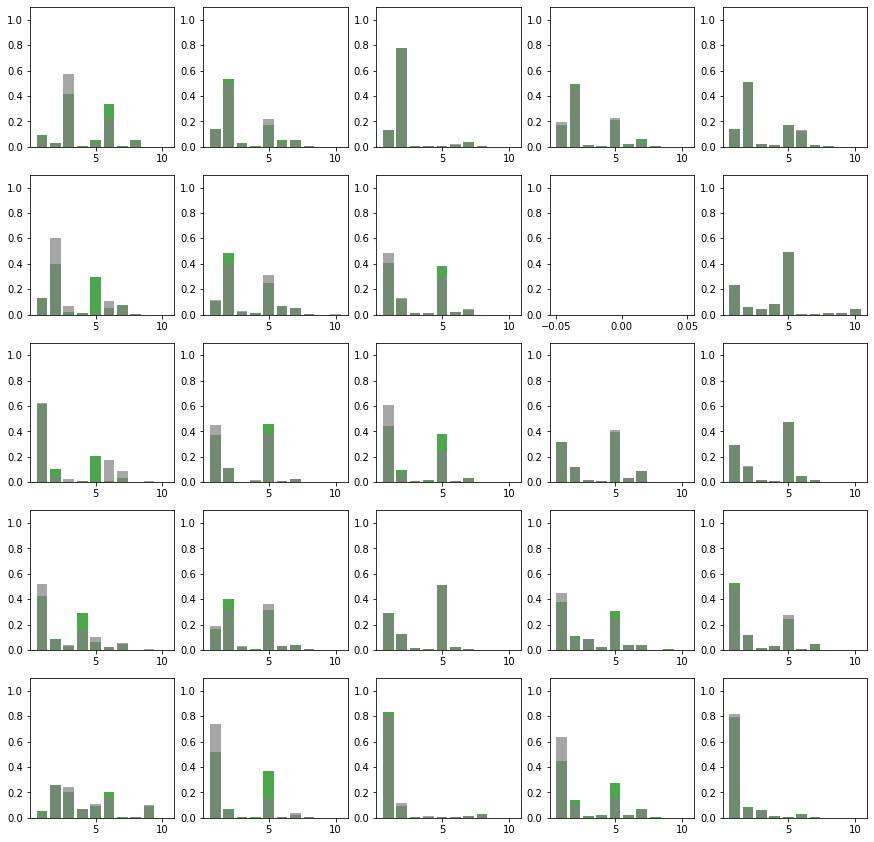

In [10]:
cols = 5
rows = int(len(selected)/cols) + 1
fig = plt.figure(figsize=(15, 3*rows))

for i, session in enumerate(selected):
    clu_profile_means, clu_profile_stds, succ_clu = get_profiles_per_cluster(session)
    AL_profile_1, _, _ = get_avg_succ_profile(session)

    clusters = np.arange(clu_profile_means.shape[0]).astype(np.int16) + 1
    syll_ids = np.arange(clu_profile_means.shape[1]).astype(np.int16) + 1
    
    AL_profile_2 = clu_profile_means[np.where(np.isin(clusters, succ_clu))[0]].mean(axis=0)

    ax = fig.add_subplot(rows, cols, i+1)
    ax.bar(syll_ids, AL_profile_1, alpha=0.7, color='green')
    ax.bar(syll_ids, AL_profile_2, alpha=0.7, color='gray')
    ax.set_ylim(0, 1.1)

## PCA of behavioral clusters across sessions

In [11]:
selected = sessions[:]
selected

['57_SIT_2023-12-18_14-07-34',
 '57_SIT_2023-12-22_14-08-07',
 '57_SIT_2023-12-22_14-43-58',
 '57_SIT_2023-12-22_17-37-18',
 '57_SIT_2023-12-23_14-21-01',
 '57_SIT_2023-12-28_16-43-28',
 '57_SIT_2023-12-29_11-06-26',
 '57_SIT_2023-12-29_11-40-14',
 '57_SIT_2023-12-29_12-11-46',
 '57_SIT_2024-01-02_14-43-18',
 '57_SIT_2024-01-02_16-38-05',
 '57_SIT_2024-01-02_17-10-09',
 '57_SIT_2024-01-03_19-22-18',
 '57_SIT_2024-01-03_19-54-59',
 '57_SIT_2024-01-04_14-16-22',
 '57_SIT_2024-01-04_14-52-59',
 '57_SIT_2024-01-05_14-35-49',
 '57_SIT_2024-01-05_15-08-34',
 '57_SIT_2024-01-06_16-52-40',
 '57_SIT_2024-01-06_17-25-35',
 '57_SIT_2024-01-07_19-23-28',
 '57_SIT_2024-01-08_15-51-26',
 '57_SIT_2024-01-12_13-23-02',
 '57_SIT_2024-01-15_13-45-22',
 '57_SIT_2024-01-15_14-34-48']

In [12]:
profiles = []  # profiles for all sessions all clusters
labels   = []  # labels for each profile (AL / Other)

for i, session in enumerate(selected):
    clu_profile_means, clu_profile_stds, succ_clu = get_profiles_per_cluster(session)
    
    for j, profile in enumerate(clu_profile_means):
        profiles.append(profile)
        labels.append(1 if j+1 in succ_clu else 0)
        
profiles = np.array(profiles)
labels   = np.array(labels)

idxs_AL = np.where(labels == 1)[0]
idxs_PH = np.where(labels == 0)[0]

In [13]:
pca = decomposition.PCA(n_components=5)
pca.fit(profiles)
X = pca.transform(profiles)

In [14]:
pca.explained_variance_ratio_

array([0.3627339 , 0.21810164, 0.18677013, 0.12163519, 0.04759587])

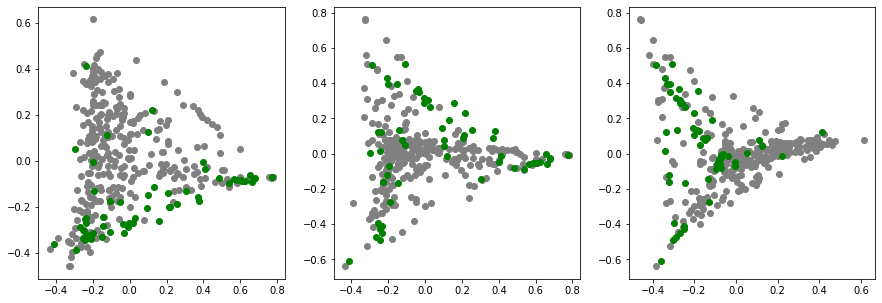

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, comb in enumerate([[0, 1], [0, 2], [1, 2]]):
    ax = axes[i]
    ax.scatter(X[idxs_PH][:, comb[0]], X[idxs_PH][:, comb[1]], color='gray')
    ax.scatter(X[idxs_AL][:, comb[0]], X[idxs_AL][:, comb[1]], color='green')
    

In [24]:
umap_2d = UMAP(n_components=2, n_neighbors=20, min_dist=0.5, random_state=0)
umap_fit = umap_2d.fit_transform(profiles)

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


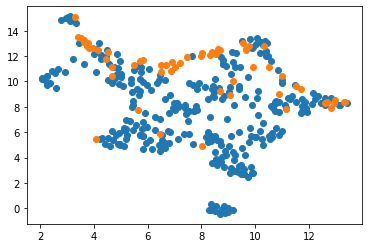

In [25]:
plt.scatter(umap_fit[idxs_PH][:, 0], umap_fit[idxs_PH][:, 1])
plt.scatter(umap_fit[idxs_AL][:, 0], umap_fit[idxs_AL][:, 1])